In [1]:
from collections import defaultdict
from copy import deepcopy
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pprint import pprint
from scipy.stats import multivariate_normal
import torch
from tqdm.auto import tqdm, trange
from transformers import LongformerTokenizerFast
from transformers.rda_utils import mn2hpstrs, mn2name, power_law_plus_constant, read_results, tn2block_start_idxs, tn2max_num_samples, tn2name, group2datasethps, plot_loss_data_curve, plot_escs, get_crossovers, save_temperature_results, adjust_preds_with_temperature, tt2max_loss, load_stats, plot_sdls, plot_loss_data_curve_prequential, get_sdls, rank_by_sdl, plot_wordtype_importances, get_mn2tn2lossmatrix, plot_heatmap, heatmap, annotate_heatmap, get_ablation2sdlincrease, plot_bars, tune_temperature, tune_std, dfs2preds_labels, preds_labels2df

In [2]:
exp2config = {
    'clevr': {
        'task_types': ('clevr-compare_integer', 'clevr-comparison', 'clevr-same_relate'),
        'analysis_type': '',
        'do_tune_temperature': False,
        'cache_mn2tn2losses': False,
        'exp_name': 'CLEVR',
        'ensemble': False,
    },
    'hotpot': {
        'task_types': ('hotpot',),
        'analysis_type': '',
        'do_tune_temperature': False,
        'cache_mn2tn2losses': False,
        'exp_name': 'HotpotQA',
        'ensemble': False,
    },
    'esnli': {
        'task_types': ('esnli',),
        'analysis_type': '',
        'do_tune_temperature': True,
        'cache_mn2tn2losses': True,
        'exp_name': 'e-SNLI',
        'ensemble': True,
    },
    'glue': {
        'task_types': ('cola', 'sst-2', 'mrpc', 'sts-b', 'qqp', 'mnli', 'qnli', 'rte'),
        'analysis_type': 'all',
        'do_tune_temperature': True,
        'cache_mn2tn2losses': True,
        'exp_name': 'GLUE',
        'ensemble': True,
    },
}

In [3]:
exp = 'esnli'

config = exp2config[exp]
task_types = config['task_types']
analysis_type = config['analysis_type']
do_tune_temperature = config['do_tune_temperature']
cache_mn2tn2losses = config['cache_mn2tn2losses']
ensemble = config['ensemble']

esnli


Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw.mn-fasttext.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked.mn-fasttext.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw,explanation.mn-fasttext.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-explanation.mn-fasttext.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked,explanation.mn-fasttext.pbn2seed2hpstr2stats.json



Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw.mn-distilgpt2.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked.mn-distilgpt2.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw,explanation.mn-distilgpt2.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-explanation.mn-distilgpt2.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked,explanation.mn-distilgpt2.pbn2seed2hpstr2stats.json



Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw.mn-gpt2.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked.mn-gpt2.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw,explanation.mn-gpt2.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-explanation.mn-gpt2.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked,explanation.mn-gpt2.pbn2seed2hpstr2stats.json



Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw.mn-albert-base-v2.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked.mn-albert-base-v2.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw,explanation.mn-albert-base-v2.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-explanation.mn-albert-base-v2.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked,explanation.mn-albert-base-v2.pbn2seed2hpstr2stats.json



Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw.mn-facebook/bart-base.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked.mn-facebook/bart-base.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw,explanation.mn-facebook/bart-base.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-explanation.mn-facebook/bart-base.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked,explanation.mn-facebook/bart-base.pbn2seed2hpstr2stats.json



Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw.mn-distilroberta-base.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked.mn-distilroberta-base.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw,explanation.mn-distilroberta-base.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-explanation.mn-distilroberta-base.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked,explanation.mn-distilroberta-base.pbn2seed2hpstr2stats.json



Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw.mn-roberta-large.from_scratch.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked.mn-roberta-large.from_scratch.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw,explanation.mn-roberta-large.from_scratch.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-explanation.mn-roberta-large.from_scratch.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked,explanation.mn-roberta-large.from_scratch.pbn2seed2hpstr2stats.json



Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw.mn-roberta-base.from_scratch.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked.mn-roberta-base.from_scratch.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw,explanation.mn-roberta-base.from_scratch.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-explanation.mn-roberta-base.from_scratch.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked,explanation.mn-roberta-base.from_scratch.pbn2seed2hpstr2stats.json



Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw.mn-roberta-large.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked.mn-roberta-large.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw,explanation.mn-roberta-large.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-explanation.mn-roberta-large.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked,explanation.mn-roberta-large.pbn2seed2hpstr2stats.json



Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw.mn-roberta-base.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked.mn-roberta-base.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-raw,explanation.mn-roberta-base.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-explanation.mn-roberta-base.pbn2seed2hpstr2stats.json
Loading cached_test_results_file from: /home/ejp416/checkpoint/complexity/tn-esnli.input-marked,explanation.mn-roberta-base.pbn2seed2hpstr2stats.json

defaultdict(<class 'int'>, {})
Temperature: 0.1 / 0.946 / 100.0 | 0.1-100.0


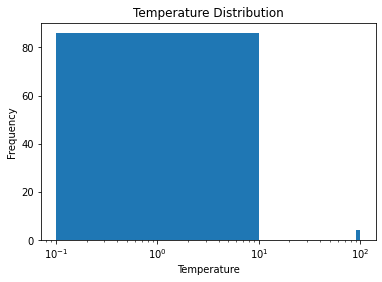

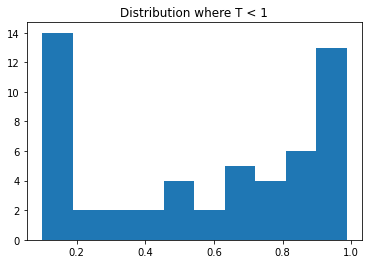

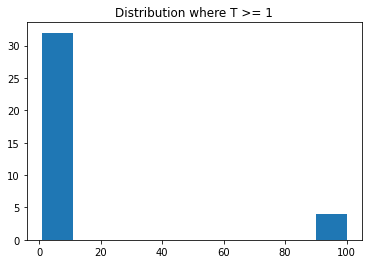

In [4]:
task_type = task_types[0]
# task_type = task_types[3]
# analysis_type = 'pos'

print(task_type)
group = f'{task_type}.{analysis_type}' if len(analysis_type) > 0 else task_type
tns = group2datasethps[group]['tn']
task_type = group.split('.', 1)[0]

max_num_samples = tn2max_num_samples(tns[0])
for tn in tns:
    assert max_num_samples == tn2max_num_samples(tn), f'Expected tn2max_num_samples(tn) == {max_num_samples} but got {tn2max_num_samples(tn)}'

mns = deepcopy(group2datasethps[group]['mn'])
ntss = tn2block_start_idxs(tns[0])
pbns = list(range(len(ntss)))
if task_type.startswith('hotpot'):
    pbns = pbns[:-1]
seeds = group2datasethps[group]['seed']

average_models = ensemble
regression = task_type.lower().startswith('sts-b')
print_best_hpstr = False

mn2tn2losses_file = f'{os.getenv("HOME")}/checkpoint/complexity/group-{group}.mn2tn2losses.json'
mn2tn2losses = None
if mn2tn2losses is None:
    assert (not regression) or do_tune_temperature, f'regression ({regression}) expects do_tune_temperature = True but got ({do_tune_temperature})'
    val_loss_select_best_key = 'test_loss' if 'clevr' in group else ('val_loss_no_temperature' if do_tune_temperature else 'val_loss')
    mn2tn2losses = {mn: {tn: [[] for pbn in pbns] for tn in tns} for mn in mns}
    mn2tn2pbn2seed2predsval = {mn: {tn: {pbn: {} for pbn in pbns} for tn in tns} for mn in mns}
    mn2tn2pbn2seed2preds = {mn: {tn: {pbn: {} for pbn in pbns} for tn in tns} for mn in mns}
    mn2tn2pbn2qid2losses = {mn: {tn: {pbn: [] for pbn in pbns} for tn in tns} for mn in mns}
    diagnostic2count = defaultdict(int)
    for mn in mns[::-1]:
        for tn in tqdm(tns, desc=mn):
            cached_test_results_file = f'{os.getenv("HOME")}/checkpoint/complexity/tn-{tn}.mn-{mn}.pbn2seed2hpstr2stats.json'
            if not do_tune_temperature:
                cached_test_results_file = cached_test_results_file.replace('.pbn2seed2hpstr2stats.json', '.no_temperature.pbn2seed2hpstr2stats.json')
            if os.path.exists(cached_test_results_file):
                print('Loading cached_test_results_file from:', cached_test_results_file)
                with open(cached_test_results_file) as f:
                    pbn2seed2hpstr2stats = json.load(f)
                pbn2seed2hpstr2stats = {int(pbn): {int(seed): hpstr2stats for seed, hpstr2stats in seed2hpstr2stats.items()} for pbn, seed2hpstr2stats in pbn2seed2hpstr2stats.items()}
            else:
                pbn2seed2hpstr2stats = {pbn: {seed: {} for seed in seeds} for pbn in pbns}
                num_missing_stats = 0
                for pbn in pbns:
                    for seed in seeds:
                        hpstrs = mn2hpstrs(mn)
                        if ('clevr' not in group) and (seed != seeds[0]) and ('bs-' in hpstrs[0]) and ('lr-' in hpstrs[0]) and ('nte-' in hpstrs[0]):
                            hpstrs = [f'bs-{32 if tn.startswith("hotpot") else 0}.lr-0.nte-{hpstrs[0].split("nte-")[-1]}']

                        for hpstr in hpstrs:
                            stats, error = load_stats(tn, mn, hpstr, seed, pbn, do_tune_temperature)
                            if error is not None:  # Check for error loading stats
                                diagnostic2count[error] += 1
                                num_missing_stats += 1
                            else:
                                pbn2seed2hpstr2stats[pbn][seed][hpstr] = stats

                if num_missing_stats == 0:
                    os.makedirs(cached_test_results_file.rsplit('/', 1)[0], exist_ok=True)
                    with open(cached_test_results_file, 'w') as f:
                        json.dump(pbn2seed2hpstr2stats, f)
                else:
                    print(f'Missing {num_missing_stats} stats files. Not caching results for: tn-{tn}.mn-{mn}')

            for pbn in pbns:
                for seed in seeds:
                    hpstrs = mn2hpstrs(mn)
                    if ('clevr' not in group) and (seed != seeds[0]) and ('bs-' in hpstrs[0]) and ('lr-' in hpstrs[0]) and ('nte-' in hpstrs[0]):
                        hpstrs = [f'bs-{32 if tn.startswith("hotpot") else 0}.lr-0.nte-{hpstrs[0].split("nte-")[-1]}']

                    best_stats = {}
                    for hpstr in hpstrs:
                        stats = pbn2seed2hpstr2stats[pbn][seed][hpstr]
                        if (stats[val_loss_select_best_key] == float('nan')) or (stats[val_loss_select_best_key] >= group2datasethps[group]['bad_run_loss_threshold']):
                            diagnostic2count['bad_run'] += 1  # if bad val loss
                        elif stats[val_loss_select_best_key] < best_stats.get(val_loss_select_best_key, float('inf')):
                            best_stats = stats  # if best val loss

                    if best_stats.get(val_loss_select_best_key, float('inf')) == float('inf'):
                        print(f'No files found for tn-{tn}.mn-{mn}.pbn-{pbn}.train.log (seed-{seed})')
                        continue
                    if print_best_hpstr and (seed == seeds[0]):
                        print(f'Best: {best_hpstr}')
                    assert best_stats['test_loss'] == best_stats['avg_test_loss'], f"Expected best_stats['test_loss'] ({best_stats['test_loss']}) == best_stats['avg_test_loss'] ({best_stats['avg_test_loss']})"
                    mn2tn2losses[mn][tn][pbn].append(best_stats['avg_test_loss'])

                    if average_models:
                        val_files = [file for file in os.listdir(best_stats["save_dir"]) if file.startswith('preds.val') and file.endswith('.csv')]
                        assert len(val_files) == 1, f'Expected only one validation file but got: {val_files}'
                        preds_val = pd.read_csv(f'{best_stats["save_dir"]}/{val_files[0]}')
                        preds_test = pd.read_csv(f'{best_stats["save_dir"]}/preds.test{"" if "fasttext" in mn.lower() else ".epoch-0"}.csv')
                        if regression:
                            preds_val.insert(len(preds_val.keys()) - 1, 'variance', best_stats['temperature'])
                            preds_test.insert(len(preds_test.keys()) - 1, 'variance', best_stats['temperature'])
                        elif do_tune_temperature:
                            preds_val = adjust_preds_with_temperature(preds_val, best_stats['temperature'])
                            preds_test = adjust_preds_with_temperature(preds_test, best_stats['temperature'])
                        mn2tn2pbn2seed2predsval[mn][tn][pbn][seed] = preds_val
                        mn2tn2pbn2seed2preds[mn][tn][pbn][seed] = preds_test
                    if task_type == 'hotpot':
                        train_steps = sorted([int(f.rsplit('-', 1)[-1].split('.')[0]) for f in os.listdir(best_stats["save_dir"]) if f.startswith('predictions_dev2') and f.endswith('.json.loss')])
                        assert len(train_steps) == 1, f'Expected exactly 1 *.json.loss file for dev2 evaluation, but got evaluations at train steps: {train_steps} for {best_stats["save_dir"]}'
                        mn2tn2pbn2qid2losses[mn][tn][pbn].append(json.load(open(f'{best_stats["save_dir"]}/predictions_dev2-{train_steps[-1]}.json.loss')))

    # Print diagnostics
    pprint(diagnostic2count)
    if do_tune_temperature:
        temperatures = []
        for pbn, seed2hpstr2stats in pbn2seed2hpstr2stats.items():
            for seed, hpstr2stats in seed2hpstr2stats.items():
                for hpstr, stats in hpstr2stats.items():
                    temperatures.append(stats['temperature'])
        temperatures = np.array(temperatures)
        print(f'Temperature: {round(np.percentile(temperatures, 2.5), 3)} / {round(np.median(temperatures), 3)} / {round(np.percentile(temperatures, 97.5), 3)} | {round(np.min(temperatures), 3)}-{round(np.max(temperatures), 3)}')

        plt.hist(temperatures)
        plt.title('Temperature Distribution')
        plt.ylabel('Frequency')
        plt.xlabel('Temperature')
        plt.xscale('log')
        plt.show()

        plt.hist(temperatures[temperatures < 1])
        plt.title('Distribution where T < 1')
        plt.show()

        plt.hist(temperatures[temperatures >= 1])
        plt.title('Distribution where T >= 1')
        plt.show()

Average predictions over models...



Done averaging!


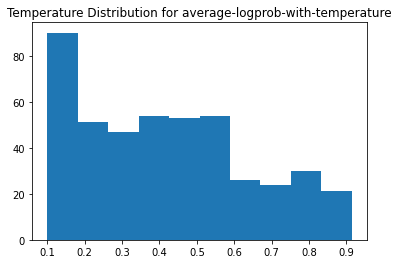

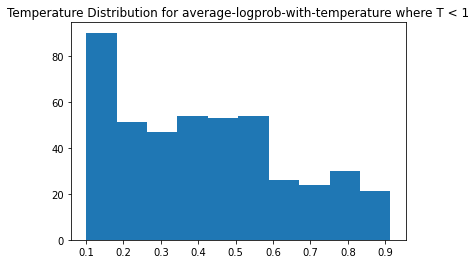

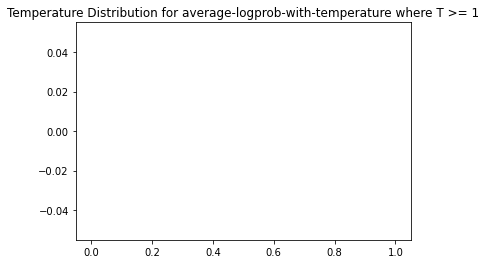

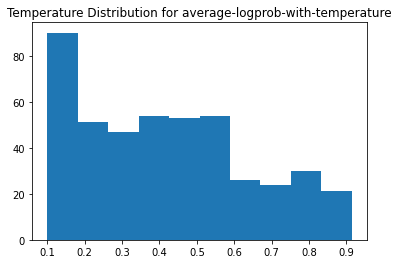

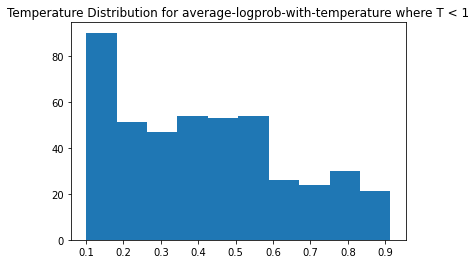

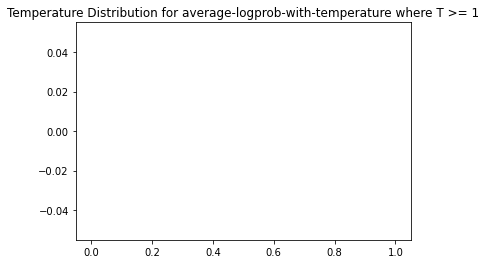

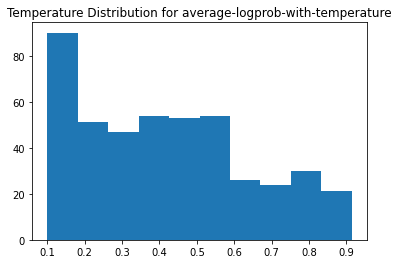

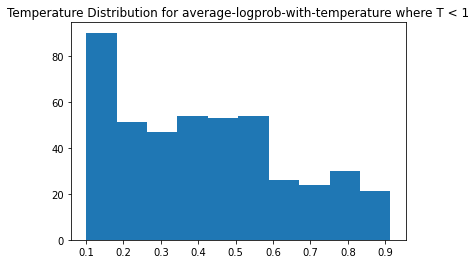

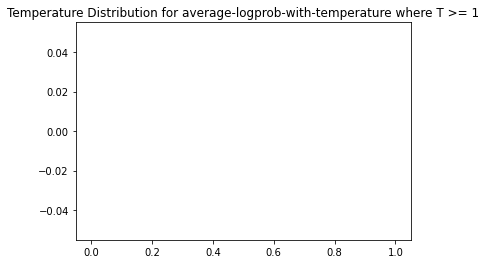

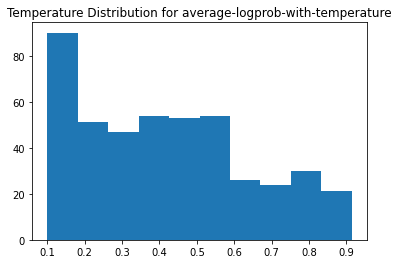

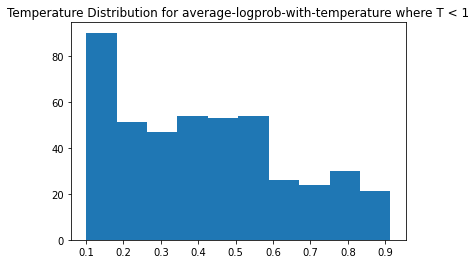

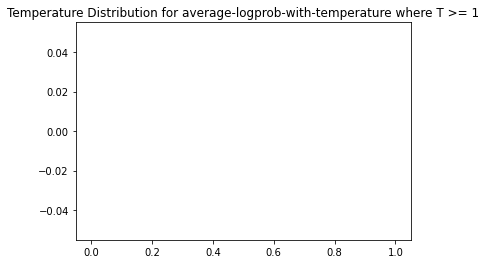

In [9]:
impute_missing_seeds = False
imputed_runs = []
print('Average predictions over models...')
loss_func = torch.nn.NLLLoss()
logsoftmax = torch.nn.LogSoftmax(dim=1)

mn2tn2pbn2temps = {}
ensemble_mns = ['average-prob']
if not regression:
    ensemble_mns.append('average-logprob')
if do_tune_temperature:
    ensemble_mns += [f'{mn}-with-temperature' for mn in ensemble_mns]
for mn in ensemble_mns:
    mn2tn2losses[mn] = {tn: [[] for pbn in pbns] for tn in tns}
    mn2tn2pbn2temps[mn] = {tn: {pbn: [] for pbn in pbns} for tn in tns if 'temperature' in mn}
for i, tn in enumerate(tns):
    for pbn in tqdm(pbns, desc=tn):
        for seed_idx in range(len(seeds)):
            dfs_val = []
            dfs = []
            for mn in mns:
                if mn in {'average-prob', 'average-logprob'}:
                    continue
                if seeds[seed_idx] in mn2tn2pbn2seed2preds[mn][tn][pbn]:
                    dfs_val.append(mn2tn2pbn2seed2predsval[mn][tn][pbn][seeds[seed_idx]])
                    dfs.append(mn2tn2pbn2seed2preds[mn][tn][pbn][seeds[seed_idx]])
                else:
                    assert impute_missing_seeds, 'Missing runs. Please impute_missing_seeds=True to fill them in with results from other random seeds.'
                    imputed = False
                    for seed_idx_offset in range(1, len(seeds)):
                        impute_seed = seeds[seed_idx - seed_idx_offset]
                        if impute_seed in mn2tn2pbn2seed2preds[mn][tn][pbn]:
                            dfs_val.append(mn2tn2pbn2seed2predsval[mn][tn][pbn][impute_seed])
                            dfs.append(mn2tn2pbn2seed2preds[mn][tn][pbn][impute_seed])
                            imputed = True
                            break
                    imputed_run = f'checkpoint/complexity/tn-{tn}.mn-{mn}*seed-{seeds[seed_idx]}.pbn-{pbn}'
                    assert imputed, f'Tried but failed to impute missing run for: ~/{imputed_run}'
                    imputed_runs.append(imputed_run)
#                 dfs = [mn2tn2pbn2seed2preds[mn][tn][pbn].get(seeds[seed_idx], mn2tn2pbn2seed2preds[mn][tn][pbn][seeds[seed_idx-1]] if impute_missing_seeds else None) for mn in mns if mn not in {'average-prob', 'average-logprob'}]
            preds_val, ref_labels_val = dfs2preds_labels(dfs_val)
            preds, ref_labels = dfs2preds_labels(dfs)
            if regression:
                assert preds_val.size(-1) == 2
                means_val = preds_val[:, :, 0]
                assert preds.size(-1) == 2
                means = preds[:, :, 0]

                mean_pred_stats = tune_std({
                    'dev': preds_labels2df(means_val.mean(0), ref_labels_val),
                    'test': preds_labels2df(means.mean(0), ref_labels),
                })

                variance = preds[:, 0, 1]
                assert torch.allclose(preds[:, :, 1], variance.unsqueeze(-1)), 'Expect constant variance'
                errors = (means - ref_labels.unsqueeze(0)).numpy()  # m x n
                all_probs = np.vstack([multivariate_normal.pdf(errors[m_no], mean=0, cov=variance[m_no].item()) for m_no in range(errors.shape[0])])
                mean_probs = all_probs.mean(axis=0)
                mn2tn2losses['average-prob'][tn][pbn].append(-np.log(mean_probs).mean())
                mn2tn2losses['average-prob-with-temperature'][tn][pbn].append(mean_pred_stats['avg_test_loss'])
                mn2tn2pbn2temps['average-prob-with-temperature'][tn][pbn].append(mean_pred_stats['temperature'])
            else:
                mean_probs_val = preds_val.mean(dim=0)
                mean_probs = preds.mean(dim=0)
                mean_probs_stats = tune_temperature({
                    'dev': preds_labels2df(mean_probs_val, ref_labels_val),
                    'test': preds_labels2df(mean_probs, ref_labels),
                })

                mean_logprobs_val = torch.log(preds_val).mean(dim=0)
                mean_logprobs = torch.log(preds).mean(dim=0)
                mean_logprobs_stats = tune_temperature({
                    'dev': preds_labels2df(mean_logprobs_val.exp(), ref_labels_val),
                    'test': preds_labels2df(mean_logprobs.exp(), ref_labels),
                })

                mn2tn2losses['average-prob'][tn][pbn].append(loss_func(logsoftmax(torch.log(mean_probs)), ref_labels).item())
                mn2tn2losses['average-logprob'][tn][pbn].append(loss_func(logsoftmax(mean_logprobs), ref_labels).item())
                mn2tn2losses['average-prob-with-temperature'][tn][pbn].append(mean_probs_stats['avg_test_loss'])
                mn2tn2losses['average-logprob-with-temperature'][tn][pbn].append(mean_logprobs_stats['avg_test_loss'])
                mn2tn2pbn2temps['average-prob-with-temperature'][tn][pbn].append(mean_probs_stats['temperature'])
                mn2tn2pbn2temps['average-logprob-with-temperature'][tn][pbn].append(mean_logprobs_stats['temperature'])

for mn in ensemble_mns:
    if mn not in mns:
        mns.append(mn)

    all_temps = []
    for tn, pbn2temps in mn2tn2pbn2temps[mn].items():
        for pbn, temps in pbn2temps.items():
            for temp in temps:
                all_temps.append(temp)
    all_temps = np.array(all_temps)

    plt.hist(all_temps)
    plt.title(f'Temperature Distribution for {mn}')
    plt.show()

    plt.hist(all_temps[all_temps < 1])
    plt.title(f'Temperature Distribution for {mn} where T < 1')
    plt.show()

    plt.hist(all_temps[all_temps >= 1])
    plt.title(f'Temperature Distribution for {mn} where T >= 1')
    plt.show()

print(f'Done averaging!')
if len(imputed_runs) > 0:
    print(f'Imputed {len(imputed_runs)} runs:')
    pprint(imputed_runs)

In [5]:
ntss = tn2block_start_idxs(tns[0])
block_starts = np.array([0] + ntss[:-1].tolist())
block_ends = ntss
block_size = block_ends - block_starts

In [7]:
mn2tn2lossmatrix = get_mn2tn2lossmatrix(mns, tns, task_type, mn2tn2losses, clip_losses_to_max=True)

In [ ]:
def get_sdls(tn2lossmatrix, sdl_tns, block_size):
    lossmeans = np.array([tn2lossmatrix[tn].mean(axis=1) for tn in sdl_tns])
    eps = max(lossmeans[:, -1])
    surplus_losses = np.clip(lossmeans - eps, a_min=0, a_max=None)
    bits_per_block = surplus_losses * block_size
    sdls = bits_per_block.sum(axis=1)
    return sdls


In [18]:
def get_all_sdls(tn2lossmatrix, sdl_tns, block_size):
    eps = max([loss for tn in sdl_tns for loss in tn2lossmatrix[tn][-1]])
    sdls = []
    for seed_idx in range(tn2lossmatrix[sdl_tns[0]].shape[1]):
        lossmeans = np.array([tn2lossmatrix[tn][:, seed_idx] for tn in sdl_tns])
        surplus_losses = np.clip(lossmeans - eps, a_min=0, a_max=None)
        bits_per_block = surplus_losses * block_size
        sdls.append(bits_per_block.sum(axis=1))
    return np.vstack(sdls).transpose()


In [33]:
all_sdls = get_all_sdls(mn2tn2lossmatrix[mn], tns[:2], block_size)

In [34]:
all_sdls

array([[1099.8477527 , 1265.68491734, 1393.38099407, 1291.98219355,
        1448.19381504],
       [  79.71908879,  367.0185676 ,  162.49440515,   89.07154495,
         111.01867879]])

In [36]:
all_sdls[1] / all_sdls[0]

array([0.07248193, 0.28997625, 0.11661879, 0.06894177, 0.0766601 ])

In [37]:
def get_ablation2sdlincrease(tns, mn, mn2tn2lossmatrix, tn_patterns=('.shuffle', '.length', '.mask_all'), return_all=False):
    ablation2sdlincrease = {}

    ntss = tn2block_start_idxs(tns[0])
    block_starts = np.array([0] + ntss[:-1].tolist())
    block_ends = ntss
    block_size = block_ends - block_starts
    for tn in tns:
        matching_tags = [tag for tag in tn_patterns if tag in tn]
        if len(matching_tags) == 0:
            continue
        ablation_name = matching_tags[0]
        sdls = (get_all_sdls if return_all else get_sdls)(mn2tn2lossmatrix[mn], [tns[0], tn], block_size)
        ablation2sdlincrease[ablation_name] = sdls[1] / sdls[0]
    return ablation2sdlincrease

In [38]:
get_ablation2sdlincrease(tns, mn, mn2tn2lossmatrix, tn_patterns=('.input-raw,explanation',), return_all=True)

{'.input-raw,explanation': array([0.16768592, 0.15464885, 0.14044469, 0.53546372, 0.46822535])}

In [39]:
get_ablation2sdlincrease(tns, mn, mn2tn2lossmatrix, tn_patterns=('.input-raw,explanation',), return_all=False)

{'.input-raw,explanation': 0.21326863534419382}

In [40]:
np.mean([0.16768592, 0.15464885, 0.14044469, 0.53546372, 0.46822535])

0.293293706

In [42]:
np.std([0.16768592, 0.15464885, 0.14044469, 0.53546372, 0.46822535]) / np.sqrt(5)

0.07684007533691094

In [27]:
mn

'roberta-base'

In [12]:
tn2lossmatrix = mn2tn2lossmatrix[mn]

In [14]:
lossmeans = np.array([tn2lossmatrix[tn].mean(axis=1) for tn in tns])
lossmeans.shape

(5, 9)

In [15]:
len(tns)

5

In [ ]:
mn2tn2lossmatrix = get_mn2tn2lossmatrix(ensemble_mns, tns, task_type, mn2tn2losses, clip_losses_to_max=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ejp416/miniconda3/envs/complexity2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-1330517bcab8>", line 1, in <module>
    mn
NameError: name 'mn' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ejp416/miniconda3/envs/complexity2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2045, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ejp416/miniconda3/envs/complexity2/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1170, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ejp416/miniconda3/envs/complexity2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-1330517bcab8>", line 1, in <module>
    mn
NameError: name 'mn' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ejp416/miniconda3/envs/complexity2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2045, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ejp416/miniconda3/envs/complexity2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/e

In [4]:
1

1

ERROR! Session/line number was not unique in database. History logging moved to new session 368




 average-prob


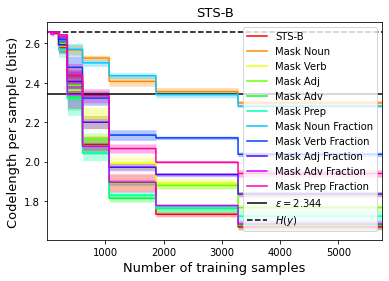



 average-prob-with-temperature


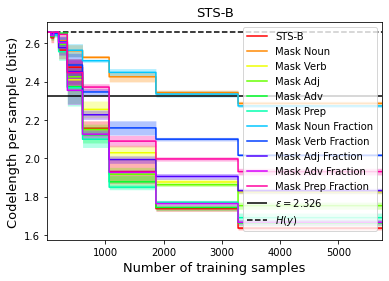

In [8]:
eps_tns = tns
for mn in ensemble_mns:
    print('\n\n', mn)
    plot_loss_data_curve_prequential(eps_tns, tns, mn, group, mn2tn2lossmatrix, confidence_interval=None, use_stderr=True, savefig=False, linestyles=('dashdot', 'dotted', 'solid') if task_type == 'clevr-comparison' else None, bbox_to_anchor=(1, .95) if exp == 'clevr' else None, plot_eps=(exp != 'clevr'), use_ylabel=(exp != 'clevr') or (tt_no == 0))

In [23]:
def plot_sdls(eps_tns, tns, mn, group, mn2tn2lossmatrix, confidence_interval=None, use_stderr=True, savefig=True, verbose=False, eps=None):
    """For a given model, set eps to be the max loss for sending the last block of data by any random seed among a set of datasets."""
    ntss = tn2block_start_idxs(tns[0])
    block_starts = np.array([0] + ntss[:-1].tolist())
    block_ends = ntss
    block_size = block_ends - block_starts

    fig, ax = plt.subplots()
    if eps is None:
        eps = max([loss for tn in eps_tns for loss in mn2tn2lossmatrix[mn][tn][-1]])
    tn2sdls = {}
    for tn_no, tn in enumerate(tns):
        losses = mn2tn2lossmatrix[mn][tn]
        surplus_losses = np.clip(losses - eps, a_min=0, a_max=None)
        eps_reached = np.allclose(surplus_losses[-1], 0)
        bits_per_block = surplus_losses * block_size.reshape(-1, 1)
        sdls = bits_per_block.sum(axis=0)
        tn2sdls[tn] = sdls
        if confidence_interval is None:
            sdl_stderr = (sdls.std() / (len(sdls) ** 0.5)) if use_stderr else sdls.std()
            plt.bar(tn_no, sdls.mean(), color=plt.cm.hsv(tn_no / len(tns)), yerr=sdl_stderr)
            if verbose:
                print(f'{tn}\t{sdls.mean()}+/-{sdl_stderr} | {sdls.mean()-sdl_stderr}-{sdls.mean()+sdl_stderr}')
            if not eps_reached:
                plt.plot(tn_no + 0.35, sdls.mean() + sdl_stderr, marker="*", linestyle="", alpha=0.8, color="k")
        else:
            sdl_median = np.median(sdls)
            lower_perc = (100. - confidence_interval) / 2.
            upper_perc = 100. - lower_perc
            sdl_lower = sdl_median - np.percentile(sdls, lower_perc)
            sdl_upper = np.percentile(sdls, upper_perc) - sdl_median
            if verbose:
                print(f'{tn}\t{sdl_median} | {np.percentile(sdls, lower_perc)}-{np.percentile(sdls, upper_perc)}')
            plt.bar(tn_no, np.median(sdls), color=plt.cm.hsv(tn_no / len(tns)), yerr=[[sdl_lower], [sdl_upper]])
            if not eps_reached:
                plt.plot(tn_no + 0.35, sdl_upper, marker="*", linestyle="", alpha=0.8, color="k")
    ax.set_xticks(range(len(tns)))
    ax.set_xticklabels([tn2name(tn) for tn in tns], rotation=45, ha='right')
    plt.ylabel(f'DeSC (bits), $\epsilon$={round(eps, 3)}')
    plt.title(f'DeSC on {tn2name(group.split(".", 1)[0])}')
    if savefig:
        plt.savefig(f'plots/DeSC.group-{group}.mn-{mn2name[mn]}.png', dpi=900, bbox_inches='tight')
        plt.savefig(f'plots/DeSC.group-{group}.mn-{mn2name[mn]}.pdf', bbox_inches='tight')
    plt.show()
    return tn2sdls




 average-prob


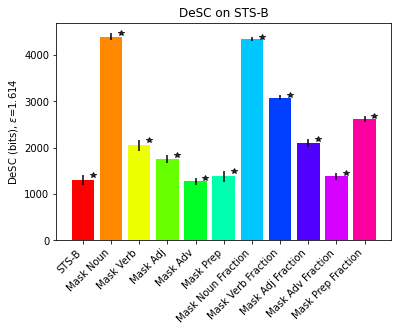



 average-prob-with-temperature


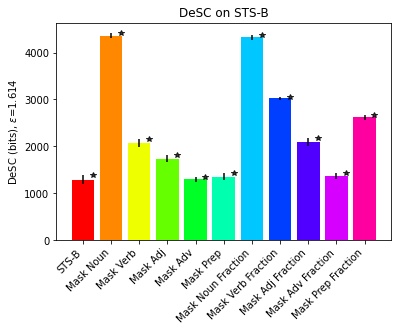

,average-prob,average-prob-with-temperature
sts-b,1300.845755,1295.272366
sts-b.mask_noun,4394.575789,4355.199466
sts-b.mask_verb,2053.884431,2070.288997
sts-b.mask_adj,1751.560270,1741.026895
sts-b.mask_adv,1270.409775,1298.615385
sts-b.mask_prep,1379.301290,1357.746764
sts-b.mask_noun_fraction,4343.020367,4320.790611
sts-b.mask_verb_fraction,3080.557076,3026.250375
sts-b.mask_adj_fraction,2108.108444,2094.194769
sts-b.mask_adv_fraction,1380.721293,1367.470106


In [58]:
# eps = 0
eps = min([loss for tn in tns for loss in mn2tn2lossmatrix[mn][tn][-1]])
mn2tn2sdl = {}
for mn in ensemble_mns:
    print('\n\n', mn)
    mn2tn2sdl[mn] = plot_sdls(eps_tns, tns, mn, group, mn2tn2lossmatrix, confidence_interval=None, use_stderr=True, savefig=False, verbose=False, eps=eps)
mn2tn2sdl = {mn: {tn: float(sdls.mean()) for tn, sdls in tn2sdl.items()} for mn, tn2sdl in mn2tn2sdl.items()}
mn2tn2sdl = pd.DataFrame(mn2tn2sdl)
mn2tn2sdl

In [50]:
mn2tn2sdl_shifted = mn2tn2sdl - np.min(mn2tn2sdl.values)

In [51]:
((mn2tn2sdl_shifted['average-prob'] - mn2tn2sdl_shifted['average-prob-with-temperature']).sum())/mn2tn2sdl_shifted['average-prob'].sum()

0.010406985492347287

In [42]:
np.round(mn2tn2sdl).astype(int)

,average-prob,average-prob-with-temperature
sts-b,1301,1295
sts-b.mask_noun,4395,4355
sts-b.mask_verb,2054,2070
sts-b.mask_adj,1752,1741
sts-b.mask_adv,1270,1299
sts-b.mask_prep,1379,1358
sts-b.mask_noun_fraction,4343,4321
sts-b.mask_verb_fraction,3081,3026
sts-b.mask_adj_fraction,2108,2094
sts-b.mask_adv_fraction,1381,1367


In [59]:
(mn2tn2sdl['average-prob'] - mn2tn2sdl['average-prob-with-temperature']) / mn2tn2sdl['average-prob']

sts-b                       0.004284
sts-b.mask_noun             0.008960
sts-b.mask_verb            -0.007987
sts-b.mask_adj              0.006014
sts-b.mask_adv             -0.022202
sts-b.mask_prep             0.015627
sts-b.mask_noun_fraction    0.005119
sts-b.mask_verb_fraction    0.017629
sts-b.mask_adj_fraction     0.006600
sts-b.mask_adv_fraction     0.009597
sts-b.mask_prep_fraction   -0.005521
dtype: float64

In [43]:
((mn2tn2sdl['average-prob'] - mn2tn2sdl['average-prob-with-temperature']).sum())/mn2tn2sdl['average-prob'].sum()

0.004741812145463259

In [38]:
eps = min([loss for tn in tns for loss in mn2tn2lossmatrix[mn][tn][-1]])

In [39]:
eps

1.6142097450203061

In [36]:
mn2tn2sdl['average-prob'].sum()

127752.33345559501

In [40]:
mn2tn2sdl

,average-prob,average-prob-with-temperature
sts-b,10580.937579,10575.36419


In [ ]:
### esnli

In [88]:
mn2tn2lossmatrix = get_mn2tn2lossmatrix(ensemble_mns, tns, task_type, mn2tn2losses, clip_losses_to_max=True)



 average-prob


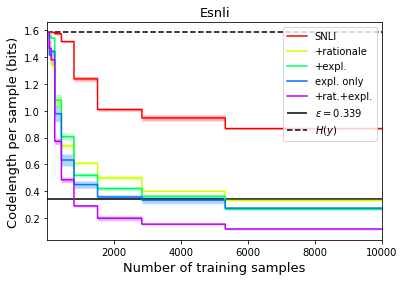



 average-prob-with-temperature


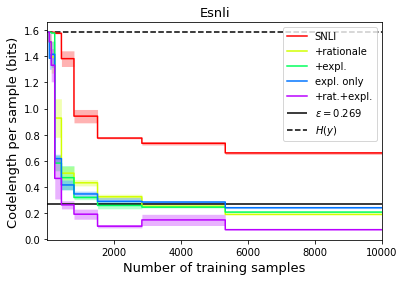



 average-logprob


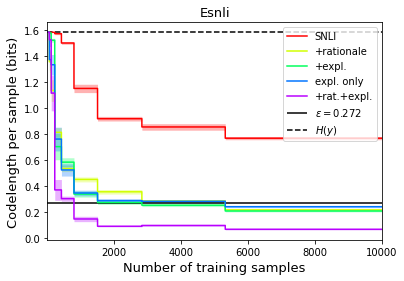



 average-logprob-with-temperature


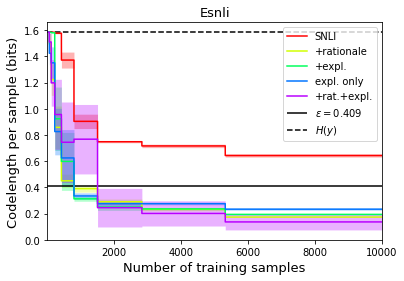

In [97]:
eps_tns = tns[1:]
for mn in ensemble_mns:
    print('\n\n', mn)
    plot_loss_data_curve_prequential(eps_tns, tns, mn, group, mn2tn2lossmatrix, confidence_interval=None, use_stderr=True, savefig=False, linestyles=('dashdot', 'dotted', 'solid') if task_type == 'clevr-comparison' else None, bbox_to_anchor=(1, .95) if exp == 'clevr' else None, plot_eps=(exp != 'clevr'), use_ylabel=(exp != 'clevr') or (tt_no == 0))



 average-prob


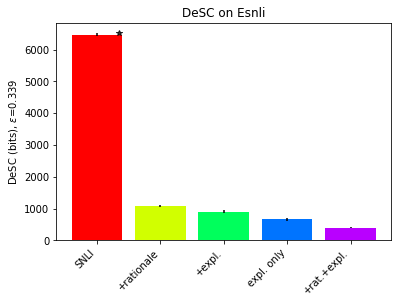



 average-prob-with-temperature


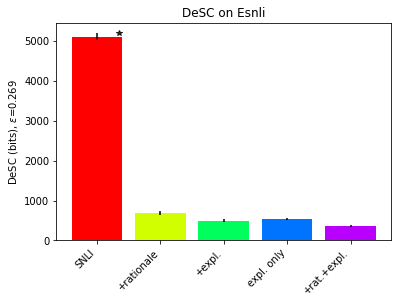



 average-logprob


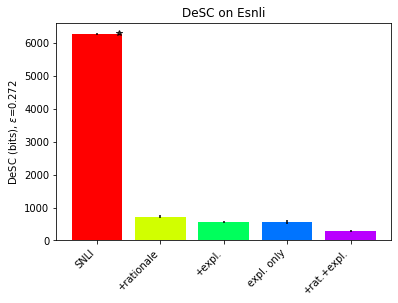



 average-logprob-with-temperature


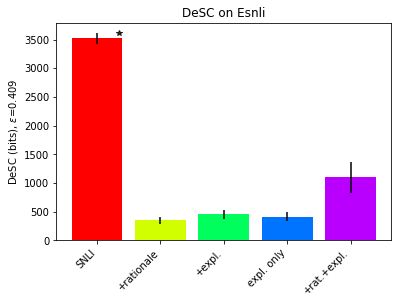

In [124]:
eps = None
mn2tn2sdl = {}
for mn in ensemble_mns:
    print('\n\n', mn)
    mn2tn2sdl[mn] = plot_sdls(eps_tns, tns, mn, group, mn2tn2lossmatrix, confidence_interval=None, use_stderr=True, savefig=False, verbose=False, eps=eps)
mn2tn2sdl = pd.DataFrame(mn2tn2sdl)



 average-prob


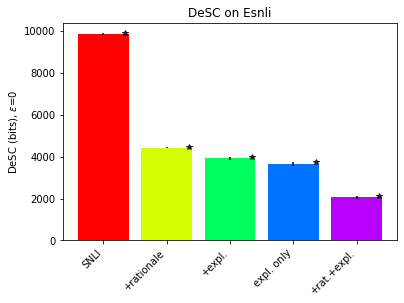



 average-prob-with-temperature


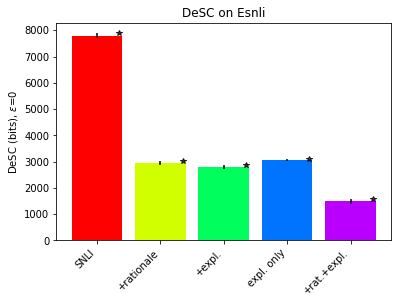



 average-logprob


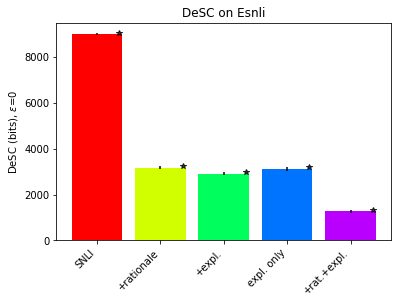



 average-logprob-with-temperature


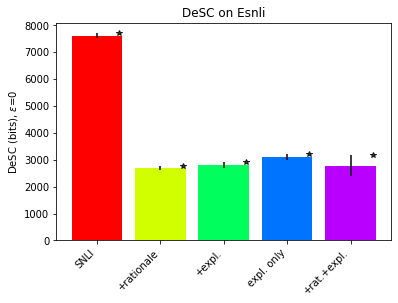

,average-prob,average-prob-with-temperature,average-logprob,average-logprob-with-temperature
esnli.input-raw,9859.923628,7798.673069,8989.978984,7612.414486
esnli.input-marked,4440.350852,2956.074860,3169.989875,2705.697852
"esnli.input-raw,explanation",3929.634383,2796.410328,2910.882311,2811.678286
esnli.input-explanation,3662.642353,3069.762401,3122.426439,3104.972460
"esnli.input-marked,explanation",2066.433334,1489.015024,1267.873750,2787.028322


In [113]:
eps = 0
mn2tn2sdl = {}
for mn in ensemble_mns:
    print('\n\n', mn)
    mn2tn2sdl[mn] = plot_sdls(tns[1:], tns, mn, group, mn2tn2lossmatrix, confidence_interval=None, use_stderr=True, savefig=False, verbose=False, eps=eps)
mn2tn2sdl = pd.DataFrame(mn2tn2sdl)

In [116]:
round(mn2tn2sdl).astype(int)

,average-prob,average-prob-with-temperature,average-logprob,average-logprob-with-temperature
esnli.input-raw,9860,7799,8990,7612
esnli.input-marked,4440,2956,3170,2706
"esnli.input-raw,explanation",3930,2796,2911,2812
esnli.input-explanation,3663,3070,3122,3105
"esnli.input-marked,explanation",2066,1489,1268,2787


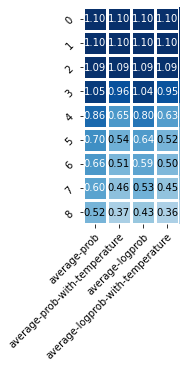

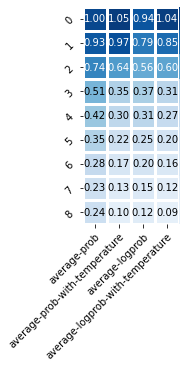

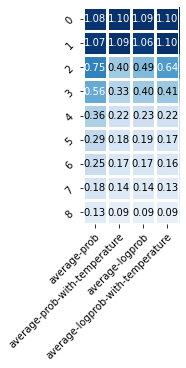

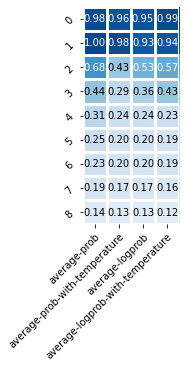

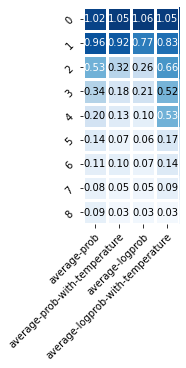

In [81]:
cmap = 'Blues'
for tn in tns:
    losses = np.hstack([np.clip(mn2tn2losses[mn][tn], a_min=0, a_max=tt2max_loss[task_type]).mean(1).reshape(-1, 1) for mn in ensemble_mns])
    fig, ax = plt.subplots()
    im, cbar = heatmap(losses, range(losses.shape[0]), keys, ax=ax, cmap=cmap, cbarlabel=None, vmin=0, vmax=tt2max_loss[task_type])
    texts = annotate_heatmap(im, valfmt="{x:.2f}")